In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

[INFO] Copying dataset 'mahmudulhaqueshawon/cat-image' to ../data/raw_data...
[INFO] Dataset ready at ../data/raw_data


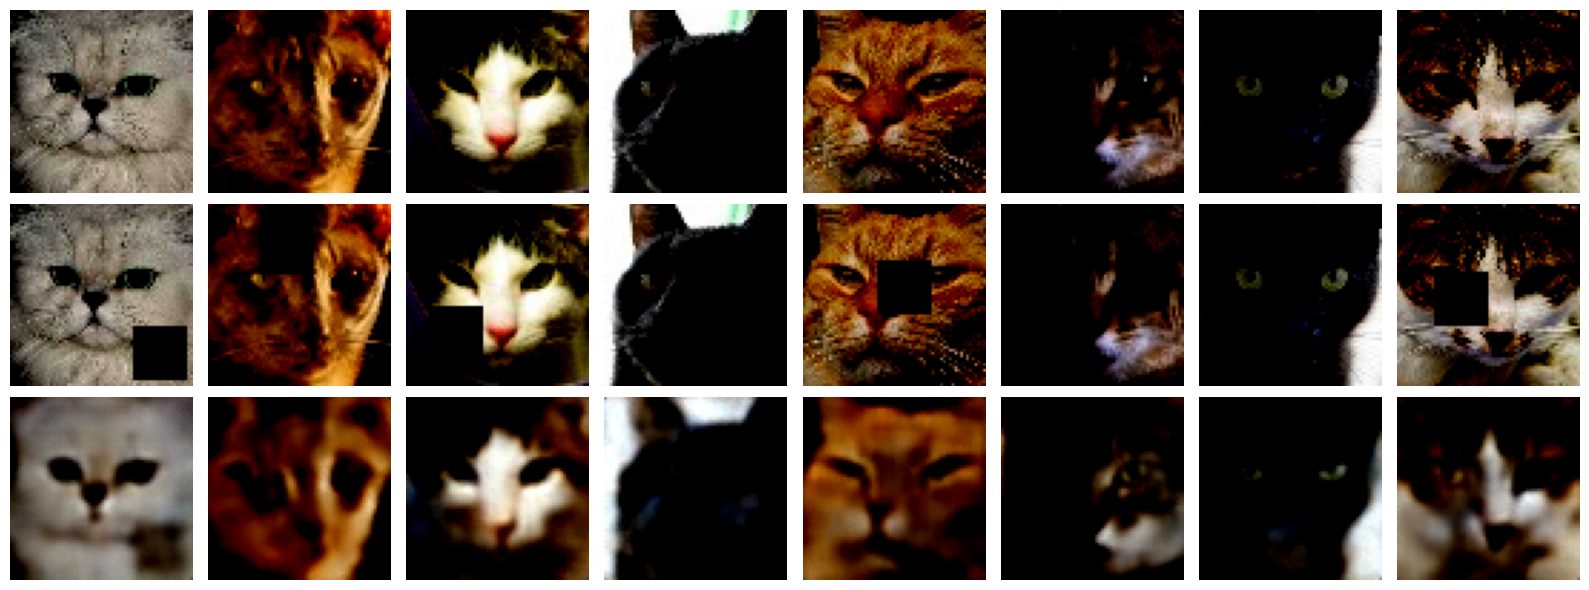

In [4]:
import torch
from src.scripts.etl_process.ETLProcessor import ETLProcessor
from src.scripts.training.MaskDataset import MaskedDataset
from src.models.treevi.TreeVI_VAE import VAEWithVIStructure
from src.models.treevi.pyg_tree.PygTreeVAE import PyGTreeVAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PyGTreeVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=2,
    latent_dim=256,
)
model.load_state_dict(
    torch.load("../models/test_run/test_treevi_event0.pt", map_location=device)
)
model = model.to(device)
model.eval()

etl = ETLProcessor(
    kaggle_dataset="mahmudulhaqueshawon/cat-image",
    raw_dir="../data/raw_data",
    split_dir="../data/data_splits",
)
train_loader, val_loader, test_loader = etl.process()

mask_size = 0.3
mask_dataset = MaskedDataset(test_loader.dataset, mask_size)
mask_loader = torch.utils.data.DataLoader(
    mask_dataset, batch_size=8, shuffle=True, num_workers=0
)


mask_img, clean_img = next(iter(mask_loader))
mask_imgs = mask_img.to(device)
original_imgs = clean_img.to(device)

with torch.no_grad():
    reconstructed = model(mask_imgs)

reconstructed = reconstructed["recon"]


def show_images(original, noisy, reconstructed, n=8):
    import numpy as np
    import matplotlib.pyplot as plt

    n = min(n, original.size(0), noisy.size(0), reconstructed.size(0))

    fig, axes = plt.subplots(3, n, figsize=(n * 2, 6))

    if isinstance(axes, np.ndarray) and axes.ndim == 1:
        axes = axes.reshape(3, -1)

    for i in range(n):
        axes[0, i].imshow(original[i].permute(1, 2, 0).cpu().clip(0, 1).numpy())
        axes[0, i].axis("off")

        axes[1, i].imshow(noisy[i].permute(1, 2, 0).cpu().clip(0, 1).numpy())
        axes[1, i].axis("off")

        axes[2, i].imshow(reconstructed[i].permute(1, 2, 0).cpu().clip(0, 1).numpy())
        axes[2, i].axis("off")

    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Noisy", fontsize=12)
    axes[2, 0].set_ylabel("Reconstructed", fontsize=12)

    plt.tight_layout()
    plt.show()


show_images(original_imgs, mask_imgs, reconstructed, n=8)

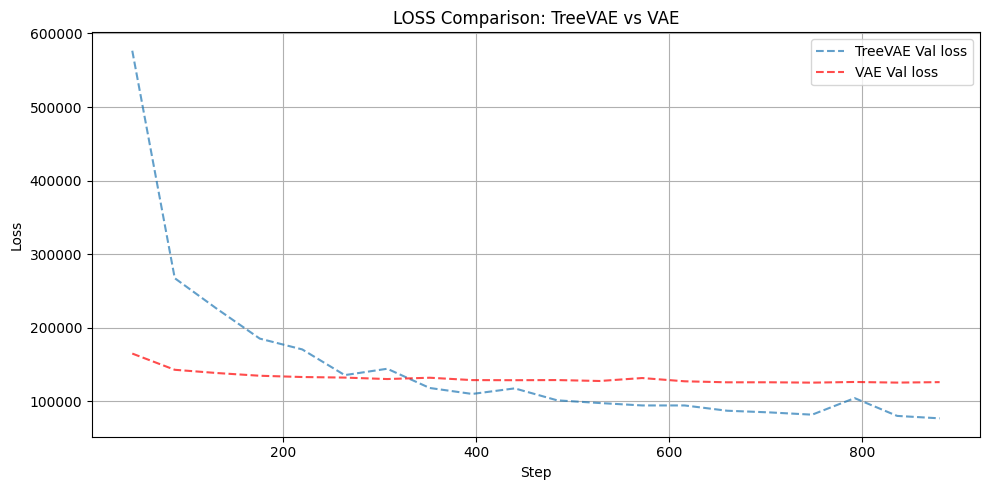

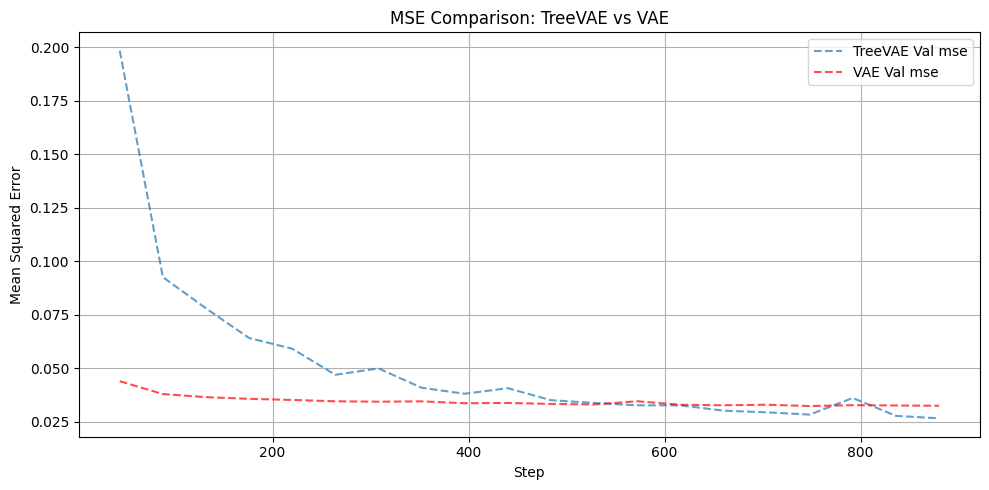

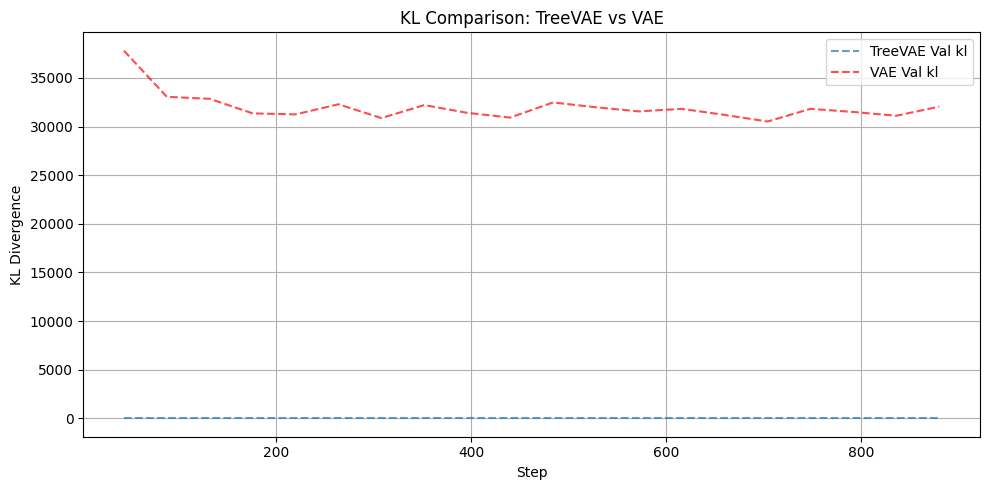

In [6]:
import json
import matplotlib.pyplot as plt

with open("../models/test_run/test_treevi_event0_metrics.json", "r") as f:
    data = json.load(f)

with open("../models/test_run/test_vae_event1_metrics.json", "r") as f:
    data_vae = json.load(f)

train_tree = data["train"]
val_tree = data["val"]
train_vae = data_vae["train"]
val_vae = data_vae["val"]


def plot_metric_compare(metric_name, ylabel):
    plt.figure(figsize=(10, 5))

    plt.plot(
        val_tree["step"],
        val_tree[metric_name],
        label=f"TreeVAE Val {metric_name}",
        alpha=0.7,
        linestyle="--",
    )

    plt.plot(
        val_vae["step"],
        val_vae[metric_name],
        label=f"VAE Val {metric_name}",
        alpha=0.7,
        linestyle="--",
        color="red",
    )

    plt.xlabel("Step")
    plt.ylabel(ylabel)
    plt.title(f"{metric_name.upper()} Comparison: TreeVAE vs VAE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_metric_compare("loss", "Loss")
plot_metric_compare("mse", "Mean Squared Error")
plot_metric_compare("kl", "KL Divergence")